### Data Collection And Preparation

### Importing the libraries

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost
import pickle as pkl
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings ("ignore")

In [3]:
class MultiColumnLabelEncoder:

    def __init__(self, columns=None):
        self.columns = columns # array of column names to encode


    def fit(self, X, y=None):
        self.encoders = {}
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            self.encoders[col] = LabelEncoder().fit(X[col])
        return self


    def transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].transform(X[col])
        return output


    def fit_transform(self, X, y=None):
        return self.fit(X,y).transform(X)


    def inverse_transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].inverse_transform(X[col])
        return output

## Read the Datasets

In [4]:
train = pd.read_csv('panic_disorder_dataset_training.csv')
train.head()

,Participant ID,Age,Gender,Family History,Personal History,Current Stressors,Symptoms,Severity,Impact on Life,Demographics,Medical History,Psychiatric History,Substance Use,Coping Mechanisms,Social Support,Lifestyle Factors,Panic Disorder Diagnosis
0,1,38,Male,No,Yes,Moderate,Shortness of breath,Mild,Mild,Rural,Diabetes,Bipolar disorder,NaN,Socializing,High,Sleep quality,0
1,2,51,Male,No,No,High,Panic attacks,Mild,Mild,Urban,Asthma,Anxiety disorder,Drugs,Exercise,High,Sleep quality,0
2,3,32,Female,Yes,No,High,Panic attacks,Mild,Significant,Urban,Diabetes,Depressive disorder,NaN,Seeking therapy,Moderate,Exercise,0
3,4,64,Female,No,No,Moderate,Chest pain,Moderate,Moderate,Rural,Diabetes,NaN,NaN,Meditation,High,Exercise,0
4,5,31,Male,Yes,No,Moderate,Panic attacks,Mild,Moderate,Rural,Asthma,NaN,Drugs,Seeking therapy,Low,Sleep quality,0


In [5]:
test = pd.read_csv('panic_disorder_dataset_testing.csv')
test.head()

,Participant ID,Age,Gender,Family History,Personal History,Current Stressors,Symptoms,Severity,Impact on Life,Demographics,Medical History,Psychiatric History,Substance Use,Coping Mechanisms,Social Support,Lifestyle Factors,Panic Disorder Diagnosis
0,1,41,Male,Yes,No,High,Shortness of breath,Mild,Mild,Urban,Diabetes,Bipolar disorder,Alcohol,Seeking therapy,Low,Exercise,0
1,2,20,Female,Yes,No,Low,Shortness of breath,Mild,Significant,Urban,Asthma,Anxiety disorder,Drugs,Exercise,High,Diet,0
2,3,32,Male,Yes,Yes,High,Panic attacks,Severe,Mild,Rural,Heart disease,Bipolar disorder,Drugs,Meditation,Moderate,Exercise,0
3,4,41,Female,Yes,Yes,Moderate,Shortness of breath,Moderate,Significant,Urban,Heart disease,Anxiety disorder,NaN,Exercise,High,Sleep quality,0
4,5,36,Female,Yes,No,High,Chest pain,Severe,Significant,Rural,Asthma,Depressive disorder,NaN,Seeking therapy,Low,Exercise,0


In [6]:
print('Train data shape:', train.shape)
print('Test data shape:', test.shape)

Train data shape: (100000, 17)
Test data shape: (20000, 17)


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Participant ID            100000 non-null  int64 
 1   Age                       100000 non-null  int64 
 2   Gender                    100000 non-null  object
 3   Family History            100000 non-null  object
 4   Personal History          100000 non-null  object
 5   Current Stressors         100000 non-null  object
 6   Symptoms                  100000 non-null  object
 7   Severity                  100000 non-null  object
 8   Impact on Life            100000 non-null  object
 9   Demographics              100000 non-null  object
 10  Medical History           74827 non-null   object
 11  Psychiatric History       75079 non-null   object
 12  Substance Use             66626 non-null   object
 13  Coping Mechanisms         100000 non-null  object
 14  Socia

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Participant ID            20000 non-null  int64 
 1   Age                       20000 non-null  int64 
 2   Gender                    20000 non-null  object
 3   Family History            20000 non-null  object
 4   Personal History          20000 non-null  object
 5   Current Stressors         20000 non-null  object
 6   Symptoms                  20000 non-null  object
 7   Severity                  20000 non-null  object
 8   Impact on Life            20000 non-null  object
 9   Demographics              20000 non-null  object
 10  Medical History           14999 non-null  object
 11  Psychiatric History       15011 non-null  object
 12  Substance Use             13383 non-null  object
 13  Coping Mechanisms         20000 non-null  object
 14  Social Support        

## Handling Missing Value

In [9]:
train.isnull().sum()

Participant ID                  0
Age                             0
Gender                          0
Family History                  0
Personal History                0
Current Stressors               0
Symptoms                        0
Severity                        0
Impact on Life                  0
Demographics                    0
Medical History             25173
Psychiatric History         24921
Substance Use               33374
Coping Mechanisms               0
Social Support                  0
Lifestyle Factors               0
Panic Disorder Diagnosis        0
dtype: int64

In [10]:
test.isnull().sum()

Participant ID                 0
Age                            0
Gender                         0
Family History                 0
Personal History               0
Current Stressors              0
Symptoms                       0
Severity                       0
Impact on Life                 0
Demographics                   0
Medical History             5001
Psychiatric History         4989
Substance Use               6617
Coping Mechanisms              0
Social Support                 0
Lifestyle Factors              0
Panic Disorder Diagnosis       0
dtype: int64

In [11]:
train.isnull().any()

Participant ID              False
Age                         False
Gender                      False
Family History              False
Personal History            False
Current Stressors           False
Symptoms                    False
Severity                    False
Impact on Life              False
Demographics                False
Medical History              True
Psychiatric History          True
Substance Use                True
Coping Mechanisms           False
Social Support              False
Lifestyle Factors           False
Panic Disorder Diagnosis    False
dtype: bool

In [12]:
test.isnull().any()

Participant ID              False
Age                         False
Gender                      False
Family History              False
Personal History            False
Current Stressors           False
Symptoms                    False
Severity                    False
Impact on Life              False
Demographics                False
Medical History              True
Psychiatric History          True
Substance Use                True
Coping Mechanisms           False
Social Support              False
Lifestyle Factors           False
Panic Disorder Diagnosis    False
dtype: bool

In [13]:
train["Medical History"].unique()

array(['Diabetes', 'Asthma', nan, 'Heart disease'], dtype=object)

In [14]:
train["Psychiatric History"].unique()

array(['Bipolar disorder', 'Anxiety disorder', 'Depressive disorder', nan],
      dtype=object)

In [15]:
train["Substance Use"].unique()

array([nan, 'Drugs', 'Alcohol'], dtype=object)

In [16]:
test["Medical History"].unique()

array(['Diabetes', 'Asthma', 'Heart disease', nan], dtype=object)

In [17]:
test["Psychiatric History"].unique()

array(['Bipolar disorder', 'Anxiety disorder', 'Depressive disorder', nan],
      dtype=object)

In [18]:
test["Substance Use"].unique()

array(['Alcohol', 'Drugs', nan], dtype=object)

### Fill null values

In [19]:
train["Medical History"].fillna("none", inplace=True)
train["Medical History"].unique()

array(['Diabetes', 'Asthma', 'none', 'Heart disease'], dtype=object)

In [20]:
train["Psychiatric History"].fillna("none", inplace=True)
train["Psychiatric History"].unique()

array(['Bipolar disorder', 'Anxiety disorder', 'Depressive disorder',
       'none'], dtype=object)

In [21]:
train["Substance Use"].fillna("none", inplace=True)
train["Substance Use"].unique()

array(['none', 'Drugs', 'Alcohol'], dtype=object)

In [22]:
test["Medical History"].fillna("none", inplace=True)
test["Medical History"].unique()

array(['Diabetes', 'Asthma', 'Heart disease', 'none'], dtype=object)

In [23]:
test["Psychiatric History"].fillna("none", inplace=True)
test["Psychiatric History"].unique()

array(['Bipolar disorder', 'Anxiety disorder', 'Depressive disorder',
       'none'], dtype=object)

In [24]:
test["Substance Use"].fillna("none", inplace=True)
test["Substance Use"].unique()

array(['Alcohol', 'Drugs', 'none'], dtype=object)

### Checking null values again

In [25]:
train.isnull().any()

Participant ID              False
Age                         False
Gender                      False
Family History              False
Personal History            False
Current Stressors           False
Symptoms                    False
Severity                    False
Impact on Life              False
Demographics                False
Medical History             False
Psychiatric History         False
Substance Use               False
Coping Mechanisms           False
Social Support              False
Lifestyle Factors           False
Panic Disorder Diagnosis    False
dtype: bool

In [26]:
test.isnull().any()

Participant ID              False
Age                         False
Gender                      False
Family History              False
Personal History            False
Current Stressors           False
Symptoms                    False
Severity                    False
Impact on Life              False
Demographics                False
Medical History             False
Psychiatric History         False
Substance Use               False
Coping Mechanisms           False
Social Support              False
Lifestyle Factors           False
Panic Disorder Diagnosis    False
dtype: bool

## Handling Categorical Values

In [27]:
#categorical values
cat_cols=[]
for i in train.columns:
    if train[i].dtype=='object':
        cat_cols.append(i)
cat_cols

['Gender',
 'Family History',
 'Personal History',
 'Current Stressors',
 'Symptoms',
 'Severity',
 'Impact on Life',
 'Demographics',
 'Medical History',
 'Psychiatric History',
 'Substance Use',
 'Coping Mechanisms',
 'Social Support',
 'Lifestyle Factors']

In [28]:
#Label Encoding
multi = MultiColumnLabelEncoder(columns= cat_cols)

train = multi.fit_transform(train)

test =  multi.fit_transform(test)

## SMOTE on Panic Disorder Diagnosis - Over Sampling The Data

In [29]:
print(train["Panic Disorder Diagnosis"].value_counts())
print(test["Panic Disorder Diagnosis"].value_counts())

Panic Disorder Diagnosis
0    95715
1     4285
Name: count, dtype: int64
Panic Disorder Diagnosis
0    19159
1      841
Name: count, dtype: int64


In [30]:
from imblearn.over_sampling import SMOTE
smote=SMOTE()

In [31]:
y_train = train["Panic Disorder Diagnosis"]
x_train = train.drop(columns=['Participant ID','Panic Disorder Diagnosis'],axis=1)

In [32]:
y_test = test["Panic Disorder Diagnosis"]
x_test = test.drop(columns=['Participant ID','Panic Disorder Diagnosis'],axis=1)

In [33]:
x_res_train,y_res_train = smote.fit_resample(x_train,y_train)

In [34]:
print(y_train.value_counts())
print(y_res_train.value_counts())

Panic Disorder Diagnosis
0    95715
1     4285
Name: count, dtype: int64
Panic Disorder Diagnosis
0    95715
1    95715
Name: count, dtype: int64


In [35]:
x_res_train

,Age,Gender,Family History,Personal History,Current Stressors,Symptoms,Severity,Impact on Life,Demographics,Medical History,Psychiatric History,Substance Use,Coping Mechanisms,Social Support,Lifestyle Factors
0,38,1,0,1,2,4,0,0,0,1,1,2,3,0,2
1,51,1,0,0,0,3,0,0,1,0,0,1,0,0,2
2,32,0,1,0,0,3,0,2,1,1,2,2,2,2,1
3,64,0,0,0,2,0,1,1,0,1,3,2,1,0,1
4,31,1,1,0,2,3,0,1,0,0,3,1,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191425,49,0,1,0,0,4,1,1,0,1,0,0,3,1,2
191426,39,0,1,0,0,0,0,2,0,2,0,2,2,0,2
191427,28,1,0,1,0,2,0,2,1,1,2,0,0,0,2
191428,41,1,1,1,0,3,2,0,1,1,1,0,3,1,2


In [36]:
y_res_train

0         0
1         0
2         0
3         0
4         0
         ..
191425    1
191426    1
191427    1
191428    1
191429    1
Name: Panic Disorder Diagnosis, Length: 191430, dtype: int64

## Feature Selection

In [37]:
#Calculating Fscore and p value
f_p_values=chi2(x_res_train,y_res_train)
f_p_values
# Here first array has F values and second array has P values.

(array([   88.59916712,  2790.96758176,    89.77534216,   399.74304265,
        36857.34928076,   318.80342431,  3350.57680519,  4873.53250903,
         6344.72625698,  7467.64608001,  5328.66904827,  4861.24873552,
          293.9305312 ,  1672.87197518, 35569.11363017]),
 array([4.83492719e-21, 0.00000000e+00, 2.66798847e-21, 6.26427884e-89,
        0.00000000e+00, 2.63962866e-71, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        6.92067811e-66, 0.00000000e+00, 0.00000000e+00]))

In [38]:
#p Values
p_values=pd.Series(f_p_values[1])
p_values.index= x_train.columns
p_values.sort_index(ascending=True)
# We sort the P values array based on the Chi scores and select moderately important and least important feature/s.

Age                    4.834927e-21
Coping Mechanisms      6.920678e-66
Current Stressors      0.000000e+00
Demographics           0.000000e+00
Family History         2.667988e-21
Gender                 0.000000e+00
Impact on Life         0.000000e+00
Lifestyle Factors      0.000000e+00
Medical History        0.000000e+00
Personal History       6.264279e-89
Psychiatric History    0.000000e+00
Severity               0.000000e+00
Social Support         0.000000e+00
Substance Use          0.000000e+00
Symptoms               2.639629e-71
dtype: float64

## Data Transformation using StandardScaler

In [39]:
scaler = StandardScaler()
x_res_train = pd.DataFrame(scaler.fit_transform(x_res_train), columns=x_train.columns)

In [40]:
x_res_train

,Age,Gender,Family History,Personal History,Current Stressors,Symptoms,Severity,Impact on Life,Demographics,Medical History,Psychiatric History,Substance Use,Coping Mechanisms,Social Support,Lifestyle Factors
0,-0.240573,1.170660,-1.017730,0.955090,1.655985,1.454123,-1.348312,-1.383105,-0.797891,-0.273364,-0.289586,1.444544,1.405798,-1.161035,0.677459
1,0.702144,1.170660,-1.017730,-1.047022,-0.827457,0.711097,-1.348312,-1.383105,1.253305,-1.213064,-1.212265,0.181618,-1.483043,-1.161035,0.677459
2,-0.675674,-0.854219,0.982579,-1.047022,-0.827457,0.711097,-1.348312,1.024039,1.253305,-0.273364,0.633093,1.444544,0.442851,1.392762,-0.616051
3,1.644862,-0.854219,-1.017730,-1.047022,1.655985,-1.517981,-0.149619,-0.179533,-0.797891,-0.273364,1.555771,1.444544,-0.520096,-1.161035,-0.616051
4,-0.748190,1.170660,0.982579,-1.047022,1.655985,0.711097,-1.348312,-0.179533,-0.797891,-1.213064,1.555771,0.181618,0.442851,0.115863,0.677459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191425,0.557111,-0.854219,0.982579,-1.047022,-0.827457,1.454123,-0.149619,-0.179533,-0.797891,-0.273364,-1.212265,-1.081308,1.405798,0.115863,0.677459
191426,-0.168056,-0.854219,0.982579,-1.047022,-0.827457,-1.517981,-1.348312,1.024039,-0.797891,0.666336,-1.212265,1.444544,0.442851,-1.161035,0.677459
191427,-0.965741,1.170660,-1.017730,0.955090,-0.827457,-0.031929,-1.348312,1.024039,1.253305,-0.273364,0.633093,-1.081308,-1.483043,-1.161035,0.677459
191428,-0.023023,1.170660,0.982579,0.955090,-0.827457,0.711097,1.049074,-1.383105,1.253305,-0.273364,-0.289586,-1.081308,1.405798,0.115863,0.677459


In [41]:
x_test = pd.DataFrame(scaler.fit_transform(x_test), columns=x_test.columns)

In [42]:
x_test

,Age,Gender,Family History,Personal History,Current Stressors,Symptoms,Severity,Impact on Life,Demographics,Medical History,Psychiatric History,Substance Use,Coping Mechanisms,Social Support,Lifestyle Factors
0,-0.035230,1.00441,1.004309,-1.002704,-1.232680,1.420198,-1.219537,-1.249351,0.991933,-0.447545,-0.448969,-1.222456,0.430382,0.000552,-0.012122
1,-1.547389,-0.99561,1.004309,-1.002704,-0.006011,1.420198,-1.219537,1.199997,0.991933,-1.341829,-1.344401,0.003924,-1.359521,-1.225128,-1.236559
2,-0.683298,1.00441,1.004309,0.997304,-1.232680,0.715193,1.234753,-1.249351,-1.008133,0.446740,-0.448969,0.003924,-0.464569,1.226232,-0.012122
3,-0.035230,-0.99561,1.004309,0.997304,1.220659,1.420198,0.007608,1.199997,0.991933,0.446740,-1.344401,1.230305,-1.359521,-1.225128,1.212315
4,-0.395268,-0.99561,1.004309,-1.002704,-1.232680,-1.399823,1.234753,1.199997,-1.008133,-1.341829,0.446462,1.230305,0.430382,0.000552,-0.012122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-0.755306,-0.99561,1.004309,0.997304,-1.232680,-1.399823,0.007608,-0.024677,-1.008133,0.446740,-0.448969,1.230305,-1.359521,1.226232,1.212315
19996,-1.043336,1.00441,-0.995709,0.997304,-1.232680,0.715193,-1.219537,-0.024677,-1.008133,-1.341829,-0.448969,-1.222456,-1.359521,-1.225128,-1.236559
19997,-1.475381,-0.99561,-0.995709,-1.002704,-0.006011,-0.694818,0.007608,1.199997,0.991933,-1.341829,-1.344401,-1.222456,1.325334,1.226232,-1.236559
19998,-0.971328,1.00441,-0.995709,0.997304,1.220659,-0.694818,-1.219537,1.199997,-1.008133,0.446740,-1.344401,1.230305,-0.464569,1.226232,1.212315


# Exploratory Data Analysis

## Descriptive Statistical

In [43]:
# reverse transforming train dataframe
train_invt = multi.inverse_transform(train)

train_invt.describe(include='all')

,Participant ID,Age,Gender,Family History,Personal History,Current Stressors,Symptoms,Severity,Impact on Life,Demographics,Medical History,Psychiatric History,Substance Use,Coping Mechanisms,Social Support,Lifestyle Factors,Panic Disorder Diagnosis
count,100000.000000,100000.000000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000.00000
unique,NaN,NaN,2,2,2,3,5,3,3,2,4,4,3,4,3,3,NaN
top,NaN,NaN,Male,Yes,No,Low,Fear of losing control,Severe,Mild,Rural,none,Bipolar disorder,Alcohol,Socializing,High,Exercise,NaN
freq,NaN,NaN,50052,50042,50210,33409,20236,33510,33452,50087,25173,25058,33445,25197,33453,33597,NaN
mean,50000.500000,41.454300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04285
std,28867.657797,13.839204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.20252
min,1.000000,18.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
25%,25000.750000,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
50%,50000.500000,41.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
75%,75000.250000,53.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000


## Age

(array([10521., 10303., 10488.,  8310., 10415., 10537.,  8275., 10564.,
        10255., 10332.]),
 array([18. , 22.7, 27.4, 32.1, 36.8, 41.5, 46.2, 50.9, 55.6, 60.3, 65. ]),
 <BarContainer object of 10 artists>)

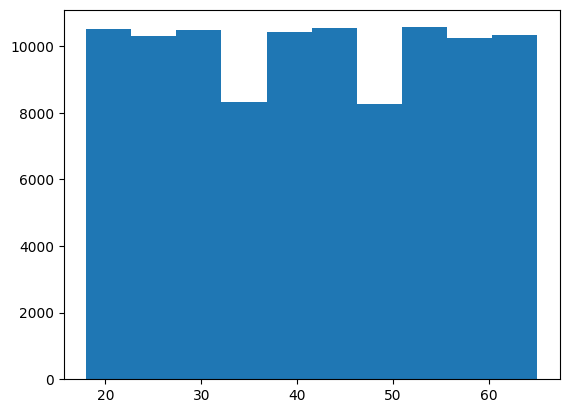

In [44]:
plt.hist(train_invt['Age'])

<Axes: xlabel='Age', ylabel='Density'>

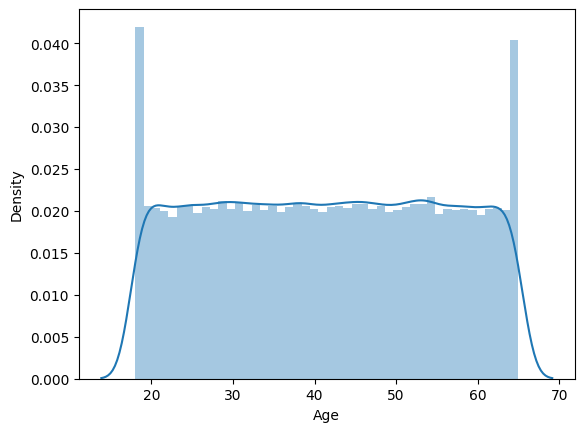

In [45]:
sns.distplot(train_invt.Age)

## Gender

[Text(0, 0, '50052'), Text(0, 0, '49948')]

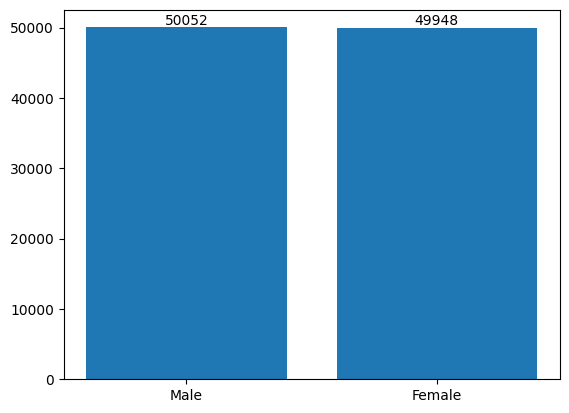

In [46]:
y_axis = train_invt['Gender'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Family History

[Text(0, 0, '50042'), Text(0, 0, '49958')]

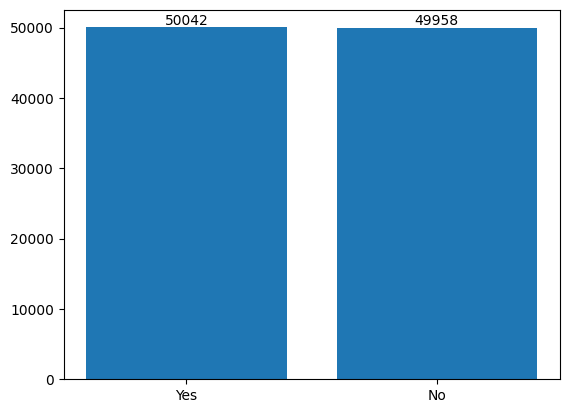

In [47]:
y_axis = train_invt['Family History'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Personal History

[Text(0, 0, '50210'), Text(0, 0, '49790')]

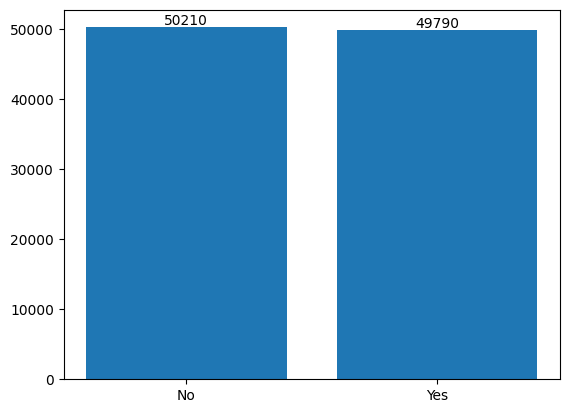

In [48]:
y_axis = train_invt['Personal History'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Current Stressors

[Text(0, 0, '33409'), Text(0, 0, '33369'), Text(0, 0, '33222')]

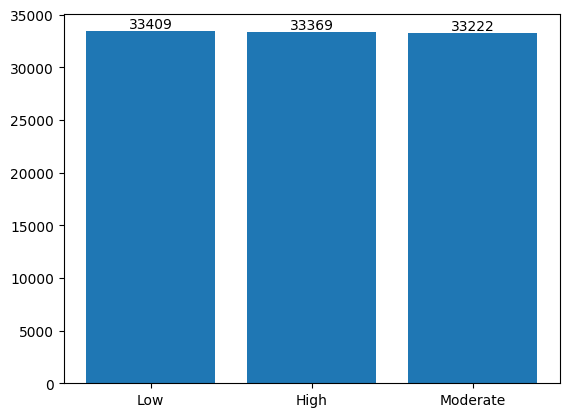

In [49]:
y_axis = train_invt['Current Stressors'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Symptoms

[Text(0, 0, '20236'),
 Text(0, 0, '20138'),
 Text(0, 0, '19949'),
 Text(0, 0, '19893'),
 Text(0, 0, '19784')]

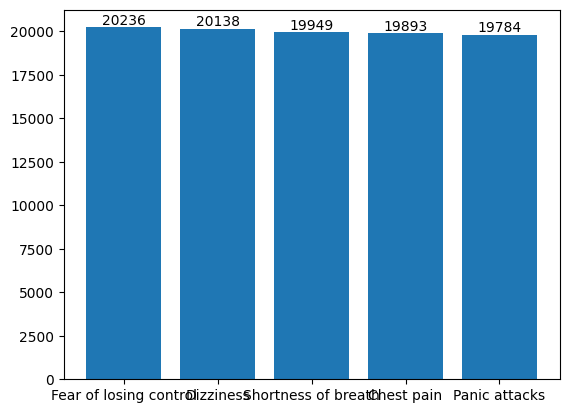

In [50]:
y_axis = train_invt['Symptoms'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Severity

[Text(0, 0, '33510'), Text(0, 0, '33365'), Text(0, 0, '33125')]

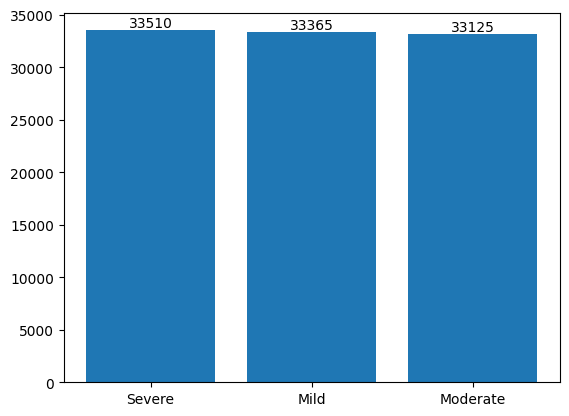

In [51]:
y_axis = train_invt['Severity'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Impact on Life

[Text(0, 0, '33452'), Text(0, 0, '33333'), Text(0, 0, '33215')]

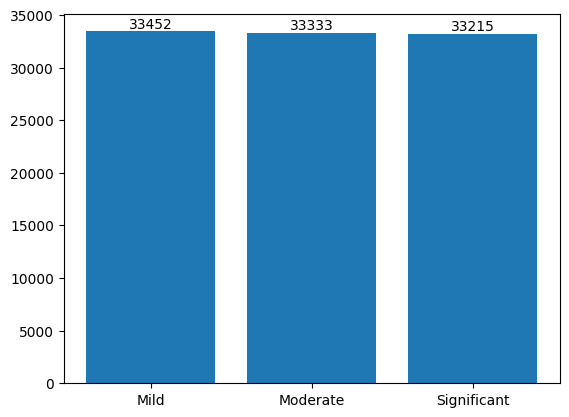

In [52]:
y_axis = train_invt['Impact on Life'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Demographics

[Text(0, 0, '50087'), Text(0, 0, '49913')]

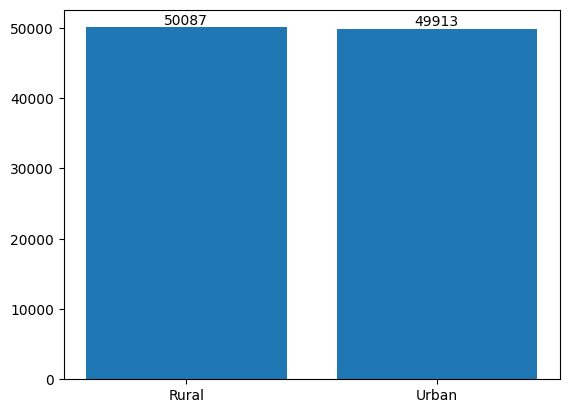

In [53]:
y_axis = train_invt['Demographics'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Medical History

[Text(0, 0, '25173'),
 Text(0, 0, '25074'),
 Text(0, 0, '24993'),
 Text(0, 0, '24760')]

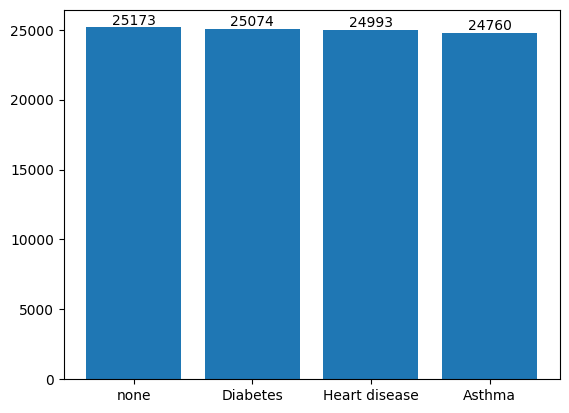

In [54]:
y_axis = train_invt['Medical History'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Psychiatric History

[Text(0, 0, '25058'),
 Text(0, 0, '25025'),
 Text(0, 0, '24996'),
 Text(0, 0, '24921')]

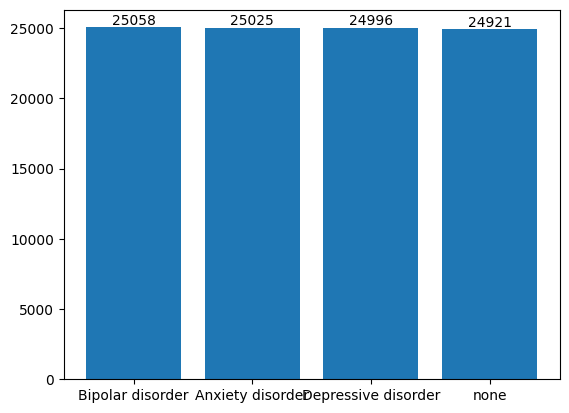

In [55]:
y_axis = train_invt['Psychiatric History'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Substance Use

[Text(0, 0, '33445'), Text(0, 0, '33374'), Text(0, 0, '33181')]

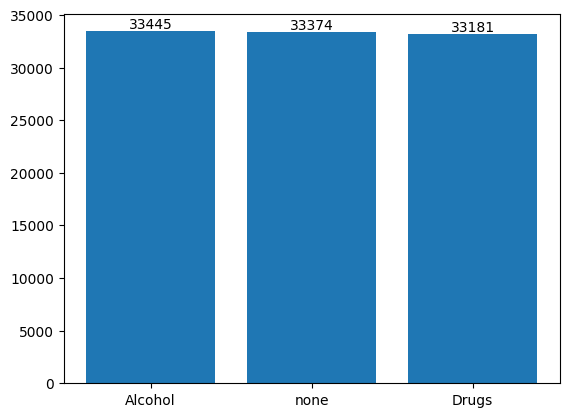

In [56]:
y_axis = train_invt['Substance Use'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Coping Mechanisms

[Text(0, 0, '25197'),
 Text(0, 0, '25037'),
 Text(0, 0, '24925'),
 Text(0, 0, '24841')]

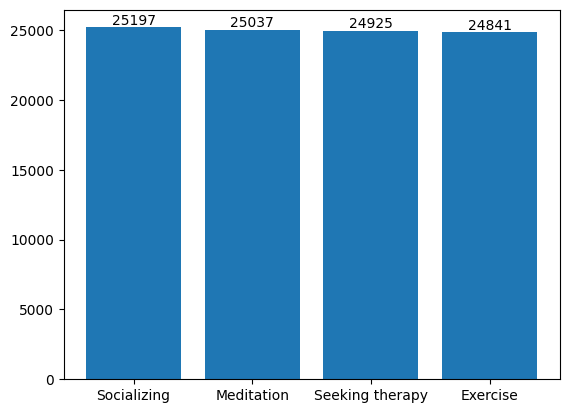

In [57]:
y_axis = train_invt['Coping Mechanisms'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Social Support

[Text(0, 0, '33453'), Text(0, 0, '33353'), Text(0, 0, '33194')]

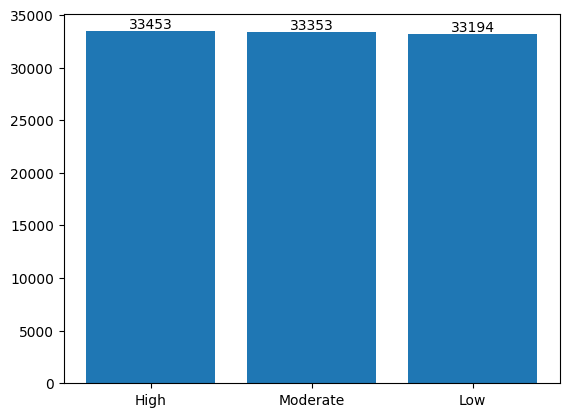

In [58]:
y_axis = train_invt['Social Support'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Lifestyle Factors

[Text(0, 0, '33597'), Text(0, 0, '33331'), Text(0, 0, '33072')]

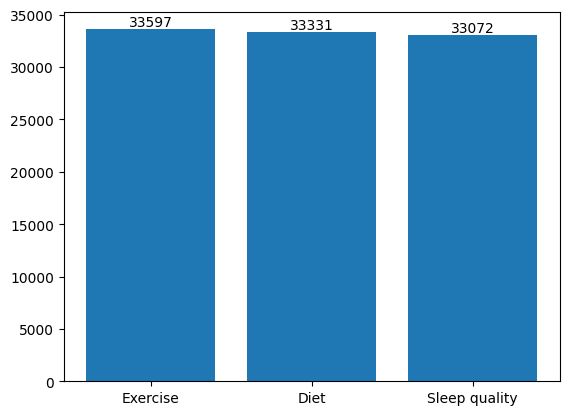

In [59]:
y_axis = train_invt['Lifestyle Factors'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Panic Disorder Diagnosis

[Text(0, 0, '95715'), Text(0, 0, '4285')]

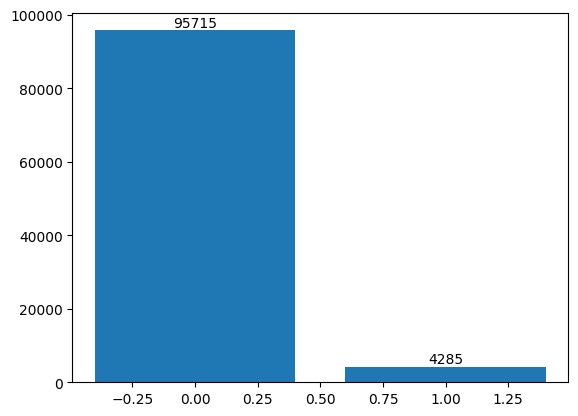

In [60]:
y_axis = train_invt['Panic Disorder Diagnosis'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

<Axes: xlabel='Panic Disorder Diagnosis', ylabel='count'>

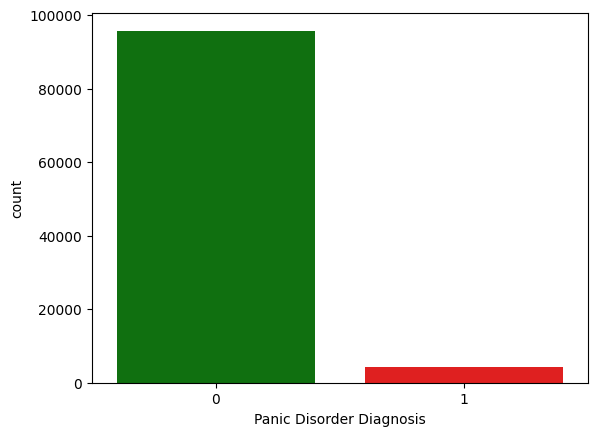

In [61]:
sns.countplot(data=train_invt,x='Panic Disorder Diagnosis',palette=['green','red'])


### Bivariate Variables 

Text(0.5, 1.0, 'Lifestyle Factors')

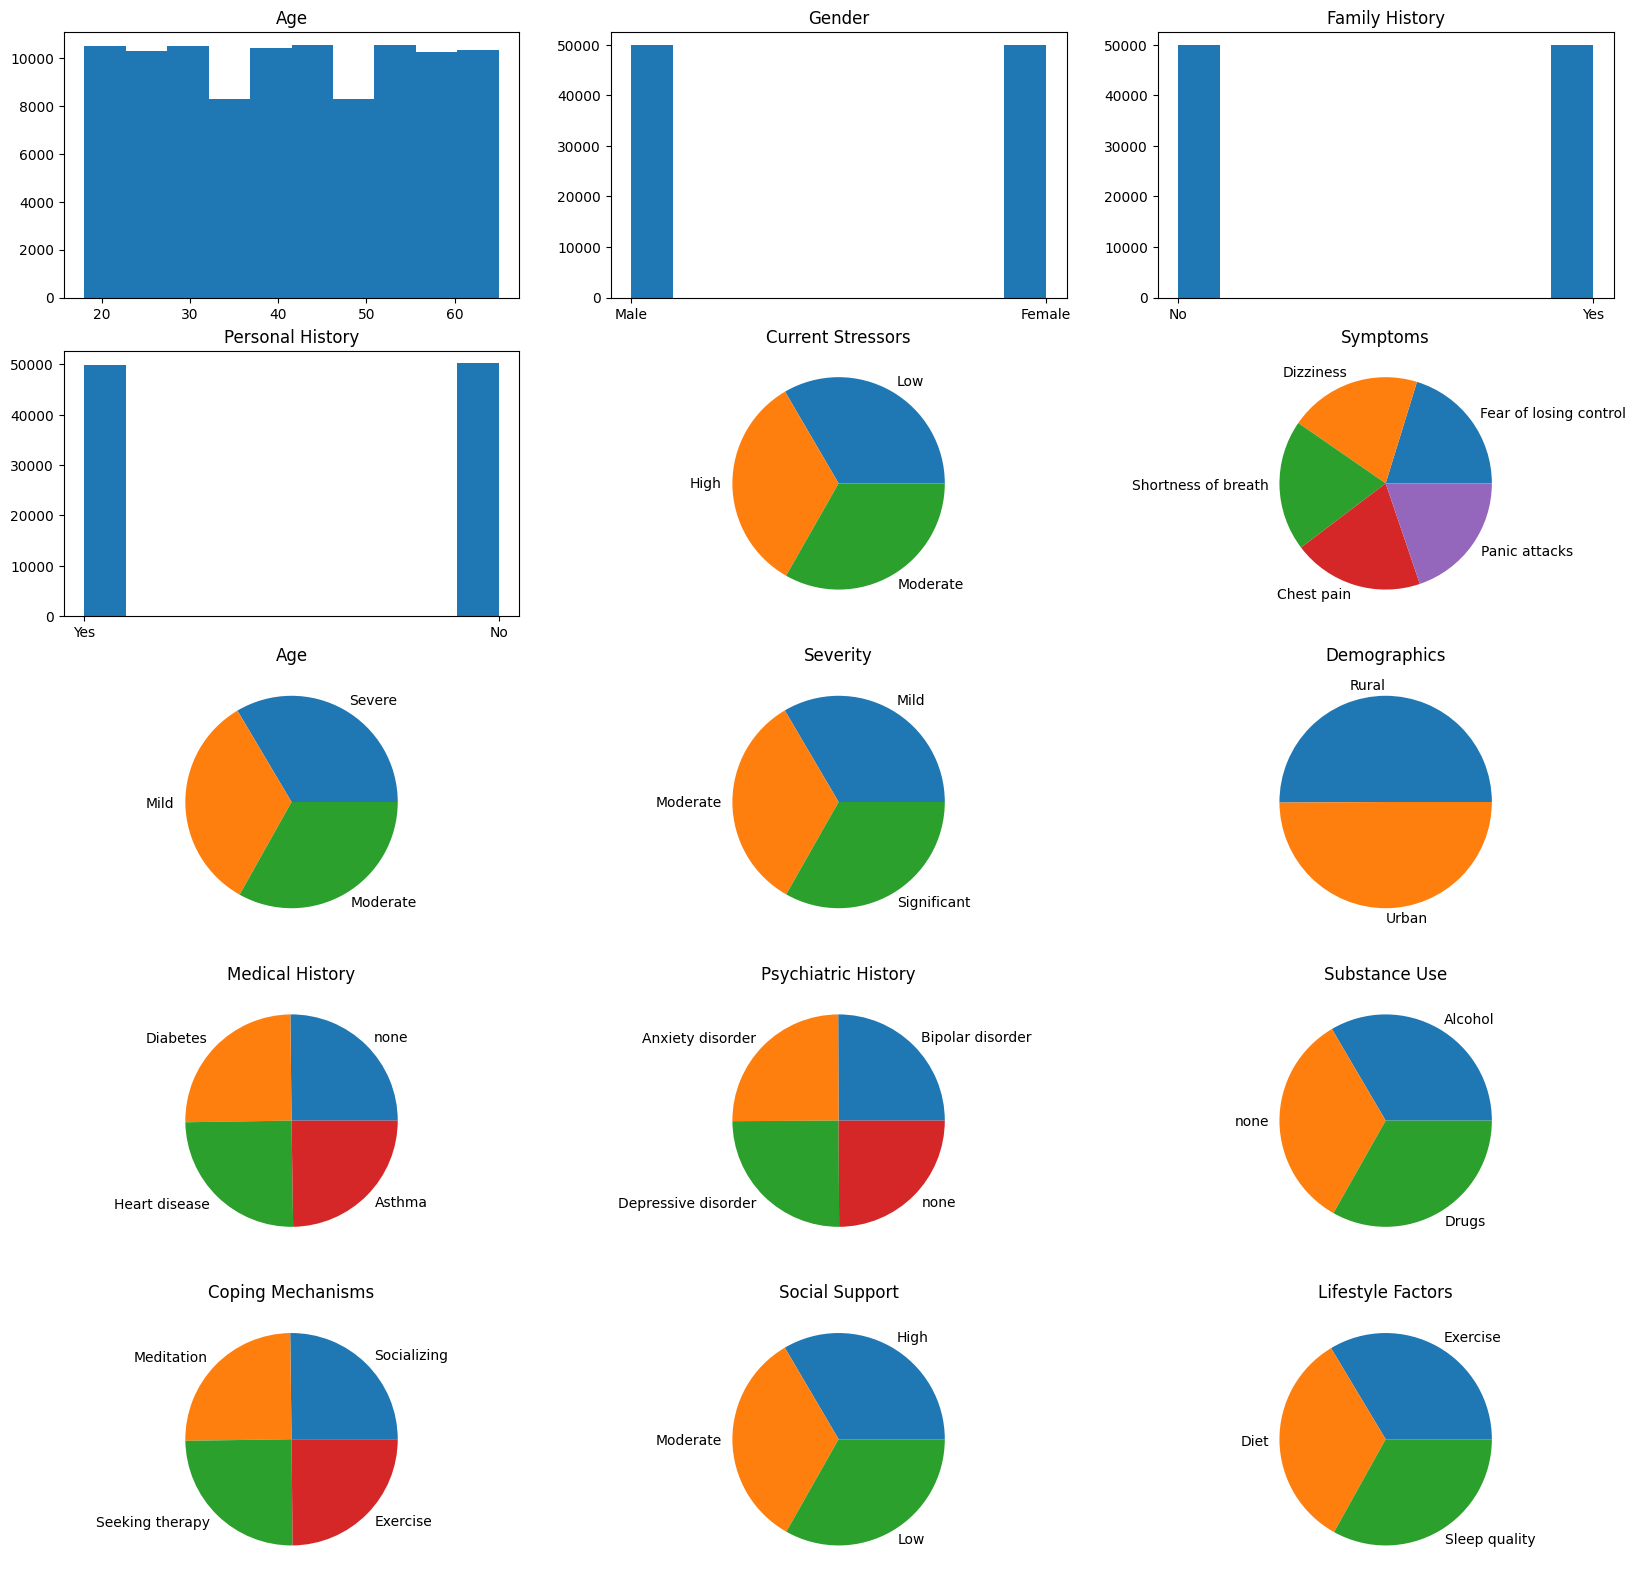

In [62]:
plt.figure(figsize=(20,20))

plt.subplot(5,3,1)
y_axis = train_invt['Age'].value_counts()
plt.hist(train['Age'])
plt.title('Age')

plt.subplot(5,3,2)
y_axis = train_invt['Gender']
plt.hist(y_axis)
plt.title('Gender')


plt.subplot(5,3,3)
y_axis = train_invt['Family History']
plt.hist(y_axis)
plt.title('Family History')


plt.subplot(5,3,4)
y_axis = train_invt['Personal History']
plt.hist(y_axis)
plt.title('Personal History')


plt.subplot(5,3,5)
y_axis = train_invt['Current Stressors'].value_counts()
plt.pie(y_axis, labels = y_axis.index)
plt.title('Current Stressors')


plt.subplot(5,3,6)
y_axis = train_invt['Symptoms'].value_counts()
plt.pie(y_axis, labels = y_axis.index)
plt.title('Symptoms')


plt.subplot(5,3,7)
y_axis = train_invt['Severity'].value_counts()
plt.pie(y_axis, labels = y_axis.index)
plt.title('Age')


plt.subplot(5,3,8)
y_axis = train_invt['Impact on Life'].value_counts()
plt.pie(y_axis, labels = y_axis.index)
plt.title('Severity')


plt.subplot(5,3,9)
y_axis = train_invt['Demographics'].value_counts()
plt.pie(y_axis, labels = y_axis.index)
plt.title('Demographics')


plt.subplot(5,3,10)
y_axis = train_invt['Medical History'].value_counts()
plt.pie(y_axis, labels = y_axis.index)
plt.title('Medical History')


plt.subplot(5,3,11)
y_axis = train_invt['Psychiatric History'].value_counts()
plt.pie(y_axis, labels = y_axis.index)
plt.title('Psychiatric History')


plt.subplot(5,3,12)
y_axis = train_invt['Substance Use'].value_counts()
plt.pie(y_axis, labels = y_axis.index)
plt.title('Substance Use')


plt.subplot(5,3,13)
y_axis = train_invt['Coping Mechanisms'].value_counts()
plt.pie(y_axis, labels=y_axis.index)
plt.title('Coping Mechanisms')


plt.subplot(5,3,14)
y_axis = train_invt['Social Support'].value_counts()
plt.pie(y_axis, labels=y_axis.index)
plt.title('Social Support')


plt.subplot(5,3,15)
y_axis = train_invt['Lifestyle Factors'].value_counts()
plt.pie(y_axis, labels = y_axis.index)
plt.title('Lifestyle Factors')



## Splitting the Data

In [63]:
print(x_res_train.shape,y_res_train.shape)
print(x_test.shape,y_test.shape)

(191430, 15) (191430,)
(20000, 15) (20000,)


## Writing Function to Train the Models 

In [66]:
#temp_x = x_res_train
#temp_y = y_res_train

def train_models_eval(x_res_train,y_res_train,fts):
    print("\n---›RANDOM FOREST" )
    rf = RandomForestClassifier(random_state=1234)
    rf.fit(x_res_train[fts], y_res_train)
    y_pred=rf.predict(x_test[fts])
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print("SCORE:",rf.score(x_test[fts],y_test))
    
    print("\n---›DECISION TREE")
    dtf = DecisionTreeClassifier(random_state=1234)
    dtf.fit(x_res_train[fts], y_res_train)
    y_pred=dtf.predict(x_test[fts])
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print("SCORE:",dtf.score(x_test[fts],y_test))
    
    print(" \n--->KNN")
    knn = KNeighborsClassifier()
    knn.fit(x_res_train[fts], y_res_train)
    y_pred=knn.predict(x_test[fts])
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print("SCORE:",knn.score(x_test[fts],y_test))
    
    print("\n---›EXTRAS TREES CLASSIFIER")
    etc = ExtraTreesClassifier(random_state=1234)
    etc.fit(x_res_train[fts],y_res_train)
    y_pred=etc.predict(x_test[fts])
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print("SCORE:",etc.score(x_test[fts],y_test))
    
    print("\n---›XGBOOST" )
    xgb = xgboost.XGBClassifier ()
    xgb.fit(x_res_train[fts], y_res_train)
    y_pred=xgb.predict(x_test[fts])
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print("SCORE:", xgb.score(x_test[fts],y_test))
    
    return rf,dtf,knn,etc,xgb

In [67]:
fts = ['Gender',
 'Family History',
 'Personal History',
 'Current Stressors',
 'Symptoms',
 'Severity',
 'Impact on Life',
 'Demographics',
 'Medical History',
 'Psychiatric History',
 'Substance Use',
 'Coping Mechanisms',
 'Social Support',
 'Lifestyle Factors']
rf,dtf,knn,etc,xgb = train_models_eval(x_res_train,y_res_train,fts)


---›RANDOM FOREST
[[18851   308]
 [   17   824]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     19159
           1       0.73      0.98      0.84       841

    accuracy                           0.98     20000
   macro avg       0.86      0.98      0.91     20000
weighted avg       0.99      0.98      0.98     20000

SCORE: 0.98375

---›DECISION TREE
[[18906   253]
 [    5   836]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19159
           1       0.77      0.99      0.87       841

    accuracy                           0.99     20000
   macro avg       0.88      0.99      0.93     20000
weighted avg       0.99      0.99      0.99     20000

SCORE: 0.9871
 
--->KNN
[[14665  4494]
 [   34   807]]
              precision    recall  f1-score   support

           0       1.00      0.77      0.87     19159
           1       0.15      0.96      0.26       841

    accuracy

In [66]:
knn.predict([x_res_train[fts].iloc[60,:]])

array([0])

In [67]:
y_test[60]

0

## Hyperparameter Tuning

### Decision Tree 

In [68]:
dtf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 1234,
 'splitter': 'best'}

In [70]:
from sklearn.model_selection import GridSearchCV

In [70]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5,10,15],
    'min_samples_split': [2,3,10],
    'min_samples_leaf': [1,2,3],
    'max_features': [None, 'sqrt', 'log2']
}

#creating a decision tree classifier
dt_classifier = DecisionTreeClassifier(random_state=1234)

#Create GridSearchCV object
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, verbose = 1, n_jobs=-1)

#Fit the data to perform grid search
grid_search.fit(x_res_train[fts], y_res_train)

#Print the best hyperparameteers
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score", grid_search.best_score_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score 0.9914015567048008


In [71]:
y_pred = grid_search.best_estimator_.predict(x_test[fts])
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("SCORE:",grid_search.best_estimator_.score(x_test[fts],y_test))

[[18898   261]
 [    4   837]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19159
           1       0.76      1.00      0.86       841

    accuracy                           0.99     20000
   macro avg       0.88      0.99      0.93     20000
weighted avg       0.99      0.99      0.99     20000

SCORE: 0.98675


### Random Forest 

In [72]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1234,
 'verbose': 0,
 'warm_start': False}

In [73]:
param_grid = {
    'n_estimators': [50,100,200],
    'max_depth': [None, 5,10],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'max_features': ['sqrt', 'log2']
}

#creating a Ramdom Forest Classifier
rf_classifier = RandomForestClassifier(random_state=1234)

#Create GridSearchCV object
grid_search = GridSearchCV(rf_classifier, param_grid=param_grid, cv=5, verbose = 1, n_jobs=4)

#Fit the data to perform grid search
grid_search.fit(x_res_train[fts], y_res_train)

#Print the best hyperparameteers
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score", grid_search.best_score_)


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score 0.9909784255341378


In [74]:
y_pred = grid_search.best_estimator_.predict(x_test[fts])
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("SCORE:",grid_search.best_estimator_.score(x_test[fts],y_test))

[[18848   311]
 [   14   827]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     19159
           1       0.73      0.98      0.84       841

    accuracy                           0.98     20000
   macro avg       0.86      0.98      0.91     20000
weighted avg       0.99      0.98      0.98     20000

SCORE: 0.98375


### XGBoost 

In [68]:
xgb.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [71]:
param_grid = {
    'min_child_weight': [10,20],
    'gamma': [0,1.5,2.0],
    'colsample_bytree': [0.6,0.8,0.9],
    'max_depth': [4,5,6],
}

xgb = xgboost.XGBClassifier(learning_rate=0.5, n_estimators=100, objective='binary:logistic', nthread=3)

fitmodel = GridSearchCV(xgb, param_grid=param_grid, cv=5, refit=True, scoring = 'accuracy', n_jobs=4, verbose=3)

#Fit the data to perform grid search
fitmodel.fit(x_res_train[fts], y_res_train)

#Print the best hyperparameteers
print("Best Hyperparameters:", fitmodel.best_params_)
print("Best Score", fitmodel.best_score_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Hyperparameters: {'colsample_bytree': 0.9, 'gamma': 0, 'max_depth': 6, 'min_child_weight': 10}
Best Score 0.9890926187118007


In [72]:
y_pred = fitmodel.best_estimator_.predict(x_test[fts])
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("SCORE:",fitmodel.best_estimator_.score(x_test[fts],y_test))

[[16546  2613]
 [    7   834]]
              precision    recall  f1-score   support

           0       1.00      0.86      0.93     19159
           1       0.24      0.99      0.39       841

    accuracy                           0.87     20000
   macro avg       0.62      0.93      0.66     20000
weighted avg       0.97      0.87      0.90     20000

SCORE: 0.869


### KNN

In [73]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
param_grid = {
    'n_neighbors': [3,5,7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [20,30,40],
    'p': [1,2]
}

knn = KNeighborsClassifier()

#Create GridSearchCV object
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, verbose = 1, n_jobs=4)

#Fit the data to perform grid search
grid_search.fit(x_res_train[fts], y_res_train)

#Print the best hyperparameteers
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score", grid_search.best_score_)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [ ]:
y_pred = grid_search.best_estimator_.predict(x_test[fts])
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("SCORE:",grid_search.best_estimator_.score(x_test[fts],y_test))

## Save Model

In [ ]:
pkl.dump(dtf, open('dtf.pkl','wb'))